# Mount and Extract 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!unzip  "/content/drive/My Drive/Colab Notebooks/lfw.zip"

In [0]:
import os
import math
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import torch.nn.functional as f
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset

# FaceNet Model

In [0]:
class faceNet(nn.Module):
    def __init__(self):
        super(faceNet, self).__init__()
        #conv1
        self.layer1 = nn.Sequential(
            
            #inputSize = 220x220x3 outputSize= 110x110x64
            nn.Conv2d(in_channels= 3, out_channels= 64, kernel_size= 7, stride= 2, padding= 3),
            #inputSize = 110x110x64 outputSize= 55x55x64
            nn.MaxPool2d(kernel_size= 3, stride= 2, padding= 1),
            nn.BatchNorm2d(num_features= 64, eps= 0.00001), #assume rnorm is batchNorm
        )
        #conv2
        self.layer2 = nn.Sequential(    
            #inputSize = 55x55x64 outputSize= 55x55x64
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 1, stride= 1, padding= 0),
            #inputSize = 55x55x64 outputSize= 55x55x192
            nn.Conv2d(in_channels= 64, out_channels= 192, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(num_features= 192, eps= 0.00001), #assume rnorm is batchNorm
            #inputSize = 55x55x192 outputSize= 28x28x192
            nn.MaxPool2d(kernel_size= 3, stride= 2, padding= 1),
        )
        #conv3
        self.layer3 = nn.Sequential(    
            #inputSize = 28x28x192 outputSize= 28x28x192
            nn.Conv2d(in_channels= 192, out_channels= 192, kernel_size= 1, stride= 1, padding= 0),
            #inputSize = 28x28x192 outputSize= 28x28x384
            nn.Conv2d(in_channels= 192, out_channels= 384, kernel_size= 3, stride= 1, padding= 1),
            #inputSize = 28x28x384 outputSize= 14x14x384
            nn.MaxPool2d(kernel_size= 3, stride= 2, padding= 1),
        )
        #conv4
        self.layer4 = nn.Sequential(    
            #inputSize = 14x14x384 outputSize= 14x14x384
            nn.Conv2d(in_channels= 384, out_channels= 384, kernel_size= 1, stride= 1, padding= 0),
            #inputSize = 14x14x384 outputSize= 14x14x256
            nn.Conv2d(in_channels= 384, out_channels= 256, kernel_size= 3, stride= 1, padding= 1),
        )
        #conv5
        self.layer5 = nn.Sequential(    
            #inputSize = 14x14x256 outputSize= 14x14x256
            nn.Conv2d(in_channels= 256, out_channels= 256, kernel_size= 1, stride= 1, padding= 0),
            #inputSize = 14x14x256 outputSize= 14x14x256
            nn.Conv2d(in_channels= 256, out_channels= 256, kernel_size= 3, stride= 1, padding= 1),
        ) 
        #conv6
        self.layer6 = nn.Sequential(        
            #inputSize = 14x14x256 outputSize= 14x14x256
            nn.Conv2d(in_channels= 256, out_channels= 256, kernel_size= 1, stride= 1, padding= 0),
            #inputSize = 14x14x256 outputSize= 14x14x256
            nn.Conv2d(in_channels= 256, out_channels= 256, kernel_size= 3, stride= 1, padding= 1),
            #inputSize = 14x14x256 outputSize= 7x7x256
            nn.MaxPool2d(kernel_size= 3, stride= 2, padding= 1),
        )
        self.FClayer = nn.Sequential(    
            #inputSize = 7x7x256 outputSize= 12544
            nn.Flatten(),
            nn.Linear(7*7*256,32*128),
            nn.Linear(32*128,32*128),
            nn.Linear(32*128,128),
        )
    def forward(self,X):
        Y = self.layer1(X)
        Y = self.layer2(Y)
        Y = self.layer3(Y)
        Y = self.layer4(Y)
        Y = self.layer5(Y)
        Y = self.layer6(Y)
        Y = self.FClayer(Y)
        Y = f.normalize(Y)
        return Y
        

# Loss Function

In [0]:
def triplet_loss(anchor, positive, negative, margin= 0.2):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        anchor,positive,negative: tensor of shape [batch_size, 128]
        margin: margin for triplet loss
    Returns:
        loss: scalar tensor containing the triplet loss
    """

    # Compute the (encoding) distance between the anchor and the positive
    distance_positive = (anchor - positive).pow(2).sum(1)
    
    # Compute the (encoding) distance between the anchor and the negative
    distance_negative = (anchor - negative).pow(2).sum(1)
    
    # subtract the two previous distances and add alpha.
    losses = f.relu(distance_positive - distance_negative + margin)

    return losses.mean()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = faceNet()
model = model.float()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

cuda:0


# Dataset Classes

In [0]:
root_dir = "/content/lfw-deepfunneled/lfw-deepfunneled/"
csv_dir = "/content/lfw_allnames.csv"  # name , imageCount(images)

In [0]:
class Triplet(Dataset):
    def __init__(self, train_set, transform = None):
        self.transform = transform
        temp = train_set.groupby(['name']).image_path.apply(lambda x: list(x.values)).reset_index()
        self._generate_triplets(temp['name'],temp.index, temp['image_path'])
        del temp
    
    def _generate_triplets(self,names, labels, image_paths): #Ids, classes:
        self.triplets = []
        num_labels = len(labels)
        for i in range(num_labels):
            #select anchor image and positive image
            
            # select a label at random to be the positive class
            positive_label = np.random.choice(labels) 
            while len(image_paths[positive_label]) < 2:
                # repeat until a class with more than 1 image is found
                positive_label = np.random.choice(labels) 
            
            #select a random image to be the anchor from the selected class
            anchor = np.random.randint(0, len(image_paths[positive_label]))
            #select a random image to be the positive from the selected class
            postive = np.random.randint(0, len(image_paths[positive_label]))
            # make sure that anchor and positive are the same image
            while anchor == postive:
                postive = np.random.randint(0, len(image_paths[positive_label]))

            #selecting negative image
            
            # select a label at random to be the negative class
            negative_label = np.random.choice(labels)
            # make sure that negative image label is not the same as anchor,positive
            while positive_label == negative_label:
                negative_label = np.random.choice(labels)
                
            negative = np.random.randint(0, len(image_paths[negative_label]))
            
            self.triplets.append([image_paths[positive_label][anchor], image_paths[positive_label][postive],
                                  image_paths[negative_label][negative], names[positive_label], names[negative_label]])
    
    def read_image(self, imgName, img_dim = 220):
        path = root_dir + str(imgName)
        im = Image.open(path)
        width, height = im.size   # Get dimensions
        left = (width - img_dim)/2
        top = (height - img_dim)/2
        right = (width + img_dim)/2
        bottom = (height + img_dim)/2
        im = im.crop((left, top, right, bottom))
        return np.array(im)

    def __len__(self):
        return len(self.triplets)
        
    def __getitem__(self, idx):
        
        anchor, positive, negative, pos_name, neg_name = self.triplets[idx]
        if self.transform:
            anchor = self.transform(self.read_image(anchor))
            positive = self.transform(self.read_image(positive))
            negative = self.transform(self.read_image(negative))
            
        sample = {'anchor': anchor, 'positive': positive, 'negative': negative,
                  'positive_name': pos_name, 'negative_name': neg_name}
   
        return sample



In [0]:
class LFWDataset(Dataset):
    def __init__(self, transform= None, train= True):
        self.train = train
        self.transform = transform
        self.train_set,self.test_set = self.train_test_split()
        
    def train_test_split(self):
        
        # copied from kaggle
        train_set = pd.read_csv(csv_dir)
        train_set = train_set.loc[train_set.index.repeat(train_set['images'])]
        train_set['image_path'] = 1 + train_set.groupby('name').cumcount()
        train_set['image_path'] = train_set.image_path.apply(lambda x: '{0:0>4}'.format(x))
        train_set['image_path'] = train_set.name + "/" + train_set.name + "_" + train_set.image_path + ".jpg"
        # end 
        
        temp = train_set.where(train_set['images'] >= 2).dropna()
        random_class = random.sample(range(temp.index[0], temp.index[-1]), 10)
        test_set = pd.DataFrame(columns= train_set.columns)
        for i in random_class:
          index = temp.index[i]
          x = temp[temp.index == index]
          x = x.dropna()
          test_set = test_set.append(x, ignore_index = True)
          del x
        del temp
        train_set = pd.merge(train_set,test_set, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
        train_set = train_set.drop(['images'], axis= 1).reset_index().drop(['index'], axis= 1) 
        test_set = test_set.drop(['images'], axis= 1).reset_index().drop(['index'], axis= 1) 
        return train_set, test_set
    
    def read_image(self, imgName, img_dim = 220):
        path = root_dir + str(imgName)
        im = Image.open(path)
        width, height = im.size   # Get dimensions
        left = (width - img_dim)/2
        top = (height - img_dim)/2
        right = (width + img_dim)/2
        bottom = (height + img_dim)/2
        im = im.crop((left, top, right, bottom))
        return np.array(im)

    def __len__(self):
        if self.train == True:
            return len(self.train_set)
        else:
            return len(self.test_set)
    
    def __getitem__(self, idx):
        if self.train == True:
          image = self.read_image(self.train_set.iloc[idx]['image_path'])
          if self.transform:
              image = self.transform(image)
            
          sample = {'image': image, 'name': self.train_set.iloc[idx]['name']}

        else:
            image = self.read_image(self.test_set.iloc[idx]['image_path'])
            if self.transform:
                image = self.transform(image)
            
            sample = {'image': image, 'name': self.test_set.iloc[idx]['name']}
        return sample


In [0]:
image_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])
dataset = LFWDataset(transform = image_transform, train= True, )
triplets = Triplet(dataset.train_set, transform= image_transform )
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)
triplet_loader = DataLoader(triplets, batch_size=64, shuffle=True, num_workers=1)

# Train

In [11]:
dataset.train = 0 
model = model.train()
torch.cuda.empty_cache()
loss_arr = []
idx = 0 
total_loss = 0
for epoch in range(10):  
    for i, batch in enumerate(triplet_loader):
        # zero the parameter gradients
        optimizer.zero_grad()
        anchor, positive, negative = batch['anchor'],batch['positive'],batch['negative']
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        anchor, positive, negative = model(anchor.float()), model(positive.float()), model(negative.float())
        loss = triplet_loss(anchor, positive, negative, margin= 0.2)
        loss.backward()
        optimizer.step()
        if(idx%100 == 0):
            loss_arr.append([idx,loss])
        total_loss += loss
        idx += 1
        del anchor
        del positive
        del negative
    torch.cuda.empty_cache()
    print('Epoch:{}, Loss:{}'.format(epoch+1, loss))
print('Finished Training')

Epoch:10, Loss:0.003505938919261098
Finished Training


# Loss Plot

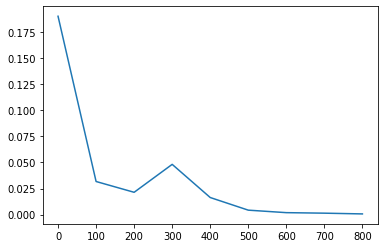

In [12]:
X = np.array([i for i,j in loss_arr])
Y = np.array([j.cpu().detach().numpy() for i,j in loss_arr])
plt.plot(X,Y)

# Test train-set

In [0]:
def flatten(data, labels, images = None):
  data_flatten = []
  labels_flatten = []
  for i in range(len(data)): #total  batches
      for j in range(len(labels[i])): #batch size
          data_flatten.append(data[i][j])
          labels_flatten.append(labels[i][j])

  return data_flatten,labels_flatten

In [0]:
torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/ADAM2faceNet.pth")

**Please restart the notebook after saving the model and then load the model if any GPU memory problems occurs from this point**

* please restart the session and run from here 
* run all blocks uptil model training loop skip torch.save and FileLink blocks also
* then upload the faceNet.pth file,if u closed the tab or restarted the session
* start execution from here after uploading

In [74]:
#model.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/ADAM2faceNet.pth"))

<All keys matched successfully>

# Model Training using KNN

In [0]:
model = model.eval()

In [0]:
dataset.train = False # shift to train mode
test_encodings = []
test_labels = []
torch.cuda.empty_cache()
for i,batch in enumerate(data_loader):
    torch.cuda.empty_cache()
    torch.no_grad()
    image, label = batch['image'], batch['name']
    image = image.to(device)
    encoding = model(image.float()) 
    test_encodings.append(encoding.cpu().detach().numpy())
    test_labels.append(label)
    del encoding
    del label
    del image

In [77]:
print(dataset.train_set.shape, dataset.test_set.shape)

(12346, 2) (887, 2)


In [0]:
encodings,labels = flatten(test_encodings,test_labels)
del test_encodings
del test_labels

In [0]:
test_set = pd.DataFrame(list(zip(labels, encodings)), columns= ["Label","Encoding"]) 
test_set = test_set.groupby(['Label']).Encoding.apply(lambda x: list(x.values)).reset_index()

In [0]:
def train_test_split(test_set, split = 0.5):
  Xtrain = []; Xtest = []; Ytrain = []; Ytest = []

  for i in range(test_set.shape[0]):
    encodings = test_set.iloc[i]['Encoding'] # image loc train  >=  image
    label = test_set.iloc[i]['Label']
    enc_len = len(encodings)
    for j in range(enc_len):
      if j <= int (enc_len * 0.5):
        Xtrain.append(encodings[j])
        Ytrain.append(label)
      else:
        Xtest.append(encodings[j])
        Ytest.append(label)
    
  return np.array(Xtrain),np.array(Xtest),np.array(Ytrain),np.array(Ytest)

In [0]:
from sklearn.metrics.pairwise import euclidean_distances 
import scipy.stats as ss

class KNearestNeighbor:
    ''' Implements the KNearest Neigbours For Classification... ''' 
    def __init__(self, k, scalefeatures=False):
        self.K=k

    def train(self, X, Y):
        nexamples,nfeatures=X.shape
        self.X_train=X
        self.Y_train=Y

    def predict(self, X):
        num_test = X.shape[0]
        y_pred = np.zeros(self.K, dtype = self.Y_train.dtype)
        pclass=[]
        compute_distance = euclidean_distances(X, self.X_train)
  
        for x in range(num_test):
            SortedDist=np.sort(compute_distance[x])
            for y in range(self.K):
                index=np.where(SortedDist[y] == compute_distance[x])
                y_pred[y]=self.Y_train[index][0]
            pclass.append(ss.mode(y_pred)[0][0])
        return np.array(pclass)

In [0]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(test_set)

In [83]:
print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)

(451, 128) (451,) (436, 128) (436,)


In [0]:
KNN = KNearestNeighbor(k=3)
KNN.train(Xtrain, Ytrain)

In [0]:
pred_train,pred_test = KNN.predict(Xtrain), KNN.predict(Xtest)

In [0]:
#Lets find the accuracy on the test set.. 
total= Ytrain.shape[0]

correct_train = incorrect_train = 0 
correct_test = incorrect_test = 0

for i in range(len(Ytest)):
  if pred_test[i] == Ytest[i]:
    correct_test += 1
  else:
    incorrect_test +=1

for i in range(len(Ytrain)):
  if pred_train[i] == Ytrain[i]:
    correct_train += 1
  else:
    incorrect_train += 1

  


In [87]:

print('Test Set Accuracy :')
print("For Xtrain : ")
print('Total correct : ',correct_train, 'Out of : ',len(Ytrain))
print('Accuracy:', (correct_train/Ytrain.shape[0] ) * 100,"%")
print("For Xtest : ")
print('Total correct : ',correct_test, 'Out of : ',len(Ytest))
print('Accuracy:', (correct_test/Ytest.shape[0] ) * 100,"%")

Test Set Accuracy :
For Xtrain : 
Total correct :  398 Out of :  451
Accuracy: 88.24833702882484 %
For Xtest : 
Total correct :  352 Out of :  436
Accuracy: 80.73394495412845 %
